## feature engineering
## KS Test for feature selection
## CV dataset building
## modelling 
## evaluation

In [1]:
#imorting libraries.
import warnings
import numpy as np
import pandas as pd
import os
from tsfresh.feature_extraction import feature_calculators
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
from random import shuffle
from tqdm import tqdm
from joblib import Parallel, delayed
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")
import pywt
import pickle

#Load more packages
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
train= pd.read_csv(os.path.join('train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
train.shape

(629145480, 2)

In [4]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


## From data discription ,we can see that the test signals of 150K points segment so we will analyse the test signal in 150k segments and try to find some meaningfull insights.

## 1) Devide the train data into chunks of 150k size.
## 2) The time_to_failure at the last time step of each segment becomes the target associated with that segment.

In [5]:
#mean_abs_deviation as per http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
from statsmodels.robust import mad
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
rows = 150000#this is the size in which the test data is given.
segments = int(np.floor(train.shape[0] / rows))#np.floor will roundup to higher side of the data which is less then data.
print("Number of segments: ", segments)

Number of segments:  4194


In [7]:
train_X = pd.DataFrame(index=None, dtype=np.float64)#empty dataframe  for train_X
train_y = pd.DataFrame(index=None, dtype=np.float64, columns=['time_to_failure'])#df for train_y

In [8]:
#Random noise of 150K points.
np.random.seed(1337)
noise = np.random.normal(0, 0.5, 150000)

#http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
#this function will denoise the given sample of data.
#Threshold equation and using hard mode in threshold as mentioned in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
#http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec( x, wavelet, mode='per')
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
# Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

In [9]:
def create_features(seg_id, seg, X):#this function will create the features.
    
    xc =seg['acoustic_data'].values#seg is the chunk of signal.
    
    xc=xc+noise#we will add noise. 
    xc=xc-np.median(xc)#median is less prone to outlier.
    
    
    
    dn=denoise_signal(xc)#this will denoise the signal.
    #Cepstrum was first introduced to characterize the seismic echoes resulting due to earthquakes.
    mfcc = librosa.feature.mfcc(xc)#https://towardsdatascience.com/how-i-understood-what-features-to-consider-while-training-audio-files-eedfb6e9002b
    mfcc_mean = mfcc.mean(axis=1) 
    
 
    X.loc[seg_id,'mfcc_0'] = mfcc_mean[0]
    X.loc[seg_id,'mfcc_1'] = mfcc_mean[1]
    X.loc[seg_id,'mfcc_2'] = mfcc_mean[2]
    X.loc[seg_id,'mfcc_3'] = mfcc_mean[3]
    X.loc[seg_id,'mfcc_4'] = mfcc_mean[4]
    X.loc[seg_id,'mfcc_5'] = mfcc_mean[5]
    X.loc[seg_id,'mfcc_6'] = mfcc_mean[6]
    X.loc[seg_id,'mfcc_7'] = mfcc_mean[7]
    X.loc[seg_id,'mfcc_8'] = mfcc_mean[8]
    X.loc[seg_id,'mfcc_9'] = mfcc_mean[9]
    X.loc[seg_id,'mfcc_10'] = mfcc_mean[10]
    X.loc[seg_id,'mfcc_11'] = mfcc_mean[11]
    X.loc[seg_id,'mfcc_12'] = mfcc_mean[12]
    X.loc[seg_id,'mfcc_13'] = mfcc_mean[13]
    X.loc[seg_id,'mfcc_14'] = mfcc_mean[14]
    X.loc[seg_id,'mfcc_15'] = mfcc_mean[15]
    X.loc[seg_id,'mfcc_16'] = mfcc_mean[16]
    X.loc[seg_id,'mfcc_17'] = mfcc_mean[17]
    X.loc[seg_id,'mfcc_18'] = mfcc_mean[18]
    X.loc[seg_id,'mfcc_19'] = mfcc_mean[19]
    
#number of peaks:this features are used to find the peaks here we are giving denoised signal to calculate peak values.
    X.loc[seg_id,'num_peak_2']=feature_calculators.number_peaks(dn, 2)
    X.loc[seg_id,'num_peak_2']=feature_calculators.number_peaks(dn, 4)
    X.loc[seg_id,'num_peak_2']=feature_calculators.number_peaks(dn, 8)
    
#Rolling window percentiles
    X.loc[seg_id,'percentile_roll_50_std_20'] = np.percentile(pd.Series(seg['acoustic_data'].values).rolling(50).std().dropna().values, 20)
    X.loc[seg_id,'percentile_roll_50_std_50'] = np.percentile(pd.Series(seg['acoustic_data'].values).rolling(50).std().dropna().values, 50)
    X.loc[seg_id,'percentile_roll_50_std_90'] = np.percentile(pd.Series(seg['acoustic_data'].values).rolling(50).std().dropna().values, 90)
    X.loc[seg_id,'percentile_roll_50_std_99'] = np.percentile(pd.Series(seg['acoustic_data'].values).rolling(50).std().dropna().values, 99)
    X.loc[seg_id,'percentile_roll_50_std_99'] = np.percentile(pd.Series(seg['acoustic_data'].values).rolling(50).std().dropna().values, 99.99)

In [10]:
# iterate over all segments for feature creation.
start=pd.DataFrame()#we will take starting of each segment.
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows :seg_id*rows +rows]#eg:0*150000 to 0*150000+150000=0:150000 like this we will itrate over all segments.
    
    create_features(seg_id, seg, train_X)#it takes three arguments seg_id,seg,df in which it will store the calculated features.
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]#it will store the values for train_y i.e last value of each segment.
    start.loc[seg_id,"start"]=seg["acoustic_data"].index[0]#segment index starting form 0.

In [11]:
train_X.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,num_peak_2,percentile_roll_50_std_20,percentile_roll_50_std_50,percentile_roll_50_std_90,percentile_roll_50_std_99
0,335.021973,26.654900,-27.984629,-18.282228,-11.369058,5.279485,-0.282514,-2.652415,-4.667602,0.778316,...,6.745740,2.936531,-1.925307,-1.778088,1.514499,3095.0,2.652761,3.148307,6.115387,59.706411
1,337.351440,28.163363,-28.435837,-18.530670,-11.027535,5.637205,-0.505431,-2.986780,-5.118212,0.283127,...,6.624786,3.020824,-2.103463,-2.464462,0.516791,3199.0,2.660674,3.141623,6.698888,93.971412
2,343.276550,33.419796,-28.321217,-21.380714,-12.873970,5.274317,-1.190987,-3.904339,-5.725098,0.236090,...,7.450770,3.118285,-2.404386,-2.721902,0.821392,3587.0,2.738687,3.294337,8.253237,62.108843
3,338.921204,30.251089,-27.569792,-18.966646,-11.228476,5.420136,-0.896508,-4.309745,-6.025020,-0.337929,...,6.170999,2.681849,-2.341608,-2.215434,1.033211,3267.0,2.672918,3.168467,6.815229,109.967944
4,339.440765,31.282936,-26.783659,-18.454132,-11.586154,4.199385,-1.776723,-3.801900,-5.444207,-0.433482,...,6.104678,2.493630,-2.454914,-2.786946,0.297990,3045.0,2.677876,3.150704,7.077097,80.862200


In [12]:
#reading submission file 

submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [13]:
submission.shape, test_X.shape

((2624, 1), (2624, 25))

In [14]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [15]:
test_X.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,num_peak_2,percentile_roll_50_std_20,percentile_roll_50_std_50,percentile_roll_50_std_90,percentile_roll_50_std_99
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,336.925903,27.986475,-27.792685,-17.634628,-11.067608,4.466018,-1.362723,-2.811437,-5.045215,-0.076625,...,6.118897,1.926561,-2.791167,-2.036318,1.307822,3247.0,2.694590,3.191890,5.844551,54.187602
seg_0012b5,336.520599,27.803291,-27.479635,-17.749317,-10.843151,4.707680,-1.673164,-3.855031,-5.495274,-0.509415,...,5.893051,1.978631,-2.729768,-2.470562,1.017127,2913.0,2.645057,3.116513,6.304388,70.529236
seg_00184e,335.581848,26.474228,-27.338898,-16.912642,-10.407048,4.681721,-1.115045,-1.374949,-3.967455,0.125379,...,5.957440,2.213510,-1.743839,-1.101627,1.793293,2604.0,2.623364,3.039603,6.091144,132.662721
seg_003339,323.358002,17.804348,-22.900347,-9.057122,-7.989621,4.074214,-1.120371,-0.721605,-2.952740,0.220439,...,3.930910,1.395905,-1.369383,-1.501081,1.256396,1296.0,2.478396,2.784798,3.904419,55.024053
seg_0042cc,332.943085,25.740061,-25.242334,-15.276909,-10.389224,3.908927,-1.778629,-3.029978,-4.403471,0.164647,...,5.854765,2.214530,-2.549621,-2.161371,1.396390,2580.0,2.587332,2.982671,5.979011,80.447778


## 5 % KS Test for Statistical feature selection:

In [16]:
#Perform KS-Test for each feature from train/test. Draw its distribution. Count features based on statistics.
hypothesisnotrejected = []
hypothesisrejected = []

for col in  tqdm_notebook(train_X.columns):
    statistic,pvalue= ks_2samp(train_X[col], test_X[col])
    if pvalue>=statistic:
        hypothesisnotrejected.append(col)#accept the null hypothesis (H0)
    if pvalue<statistic:
        hypothesisrejected.append(col)#reject the (Ho)

In [17]:
len(hypothesisnotrejected), len(hypothesisrejected)

(25, 0)

In [18]:
print(hypothesisrejected)#there is no feature which differ in there distribution.

[]


In [19]:
train_X_KS=train_X.drop([],axis=1)

In [20]:
train_X_KS.shape

(4194, 25)

In [21]:
test_X_KS=test_X.drop([],axis=1)

In [22]:
test_X_KS.shape

(2624, 25)

In [23]:
total_data=pd.concat([train_X_KS,start,train_y],axis=1)

In [24]:
total_data.to_csv("total_data.csv")

In [25]:
quake_list = np.where(np.diff(total_data['time_to_failure']) > 5)[0]#avg earthquake time.
total_data['ind'] = 0; total_data['ind'].iloc[quake_list] =1

# quake number in sequence

total_data['quake_ind'] = total_data['ind'].cumsum()
total_data.drop('ind', axis = 1, inplace = True)

In [26]:
total_data.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_18,mfcc_19,num_peak_2,percentile_roll_50_std_20,percentile_roll_50_std_50,percentile_roll_50_std_90,percentile_roll_50_std_99,start,time_to_failure,quake_ind
0,335.021973,26.654900,-27.984629,-18.282228,-11.369058,5.279485,-0.282514,-2.652415,-4.667602,0.778316,...,-1.778088,1.514499,3095.0,2.652761,3.148307,6.115387,59.706411,0.0,1.430797,0
1,337.351440,28.163363,-28.435837,-18.530670,-11.027535,5.637205,-0.505431,-2.986780,-5.118212,0.283127,...,-2.464462,0.516791,3199.0,2.660674,3.141623,6.698888,93.971412,150000.0,1.391499,0
2,343.276550,33.419796,-28.321217,-21.380714,-12.873970,5.274317,-1.190987,-3.904339,-5.725098,0.236090,...,-2.721902,0.821392,3587.0,2.738687,3.294337,8.253237,62.108843,300000.0,1.353196,0
3,338.921204,30.251089,-27.569792,-18.966646,-11.228476,5.420136,-0.896508,-4.309745,-6.025020,-0.337929,...,-2.215434,1.033211,3267.0,2.672918,3.168467,6.815229,109.967944,450000.0,1.313798,0
4,339.440765,31.282936,-26.783659,-18.454132,-11.586154,4.199385,-1.776723,-3.801900,-5.444207,-0.433482,...,-2.786946,0.297990,3045.0,2.677876,3.150704,7.077097,80.862200,600000.0,1.274400,0


In [27]:
gk=total_data.groupby(by=["quake_ind"])
gk.first()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_17,mfcc_18,mfcc_19,num_peak_2,percentile_roll_50_std_20,percentile_roll_50_std_50,percentile_roll_50_std_90,percentile_roll_50_std_99,start,time_to_failure
quake_ind,,,,,,,,,,,,,,,,,,,,,
0,335.021973,26.654900,-27.984629,-18.282228,-11.369058,5.279485,-0.282514,-2.652415,-4.667602,0.778316,...,-1.925307,-1.778088,1.514499,3095.0,2.652761,3.148307,6.115387,59.706411,0.0,1.430797
1,316.206604,12.960260,-20.163925,-4.740411,-6.841585,2.730015,-1.894233,-0.400499,-1.491331,1.080812,...,-0.566668,-0.327204,1.209156,833.0,2.418973,2.693605,3.321175,22.441346,5400000.0,0.028496
2,317.997681,13.571339,-21.396379,-5.649779,-6.782944,3.509242,-0.747450,-0.317580,-2.167683,0.625962,...,-0.672064,-1.190904,1.045470,948.0,2.433524,2.726214,3.466987,20.524453,49800000.0,0.035796
3,320.114838,14.939905,-22.554495,-7.619832,-6.817404,4.232273,-1.100614,-0.692317,-2.281854,0.705859,...,-0.824466,-0.913269,1.372740,1064.0,2.463116,2.760952,3.680561,38.628195,104400000.0,0.033796
4,320.037323,14.829563,-22.707327,-7.556711,-6.624108,4.119203,-1.180916,-0.578533,-2.587377,0.545347,...,-1.193410,-0.563724,1.423464,1120.0,2.443567,2.740475,3.654743,28.720698,138600000.0,0.006398
5,318.928772,14.264930,-21.978832,-6.867759,-6.928767,3.813486,-1.390759,-0.452420,-2.123121,0.675922,...,-0.993435,-1.566603,1.170024,934.0,2.446238,2.734810,3.511846,39.538247,187350000.0,0.036798
6,320.074005,15.185576,-22.774115,-7.669732,-7.148241,3.798551,-1.098640,-0.573491,-2.588246,0.718692,...,-1.065174,-1.396147,0.785905,1190.0,2.476090,2.764867,3.619674,56.366505,218400000.0,0.027696
7,323.627777,17.388792,-24.091061,-9.372175,-6.997273,3.843267,-2.116211,-1.461331,-2.934588,1.105593,...,-1.040305,-1.004354,1.469595,1372.0,2.474441,2.785092,4.132944,43.010857,245550000.0,0.033498
8,321.586578,16.161606,-22.680408,-8.286374,-7.238928,4.391954,-0.568907,-0.492561,-2.409537,1.221649,...,-1.898228,-1.280612,1.285787,1215.0,2.470148,2.764572,3.768830,36.348480,307650000.0,0.010298


In [28]:
etq_list = [
{"start":0,         "end":5400000},
{"start":5400000,   "end":49800000},
{"start":49800000,  "end":104400000},
{"start":104400000, "end":138600000},
{"start":138600000, "end":187350000},
{"start":187350000, "end":218400000},
{"start":218400000, "end":245550000},
{"start":245550000, "end":307650000},
{"start":307650000, "end":338100000},
{"start":338100000, "end":375150000},
{"start":375150000, "end":419100000},
{"start":419100000, "end":461550000},
{"start":461550000, "end":495600000},
{"start":495600000, "end":528600000},
{"start":528600000, "end":585300000},
{"start":585300000, "end":621985673},
{"start":621985673, "end":621750000},
]



for i, etq in enumerate(etq_list):
    total_data.loc[(total_data['start'] + 150000 >= etq["start"]) & (total_data['start'] <= etq["end"] - 150000), "eq"] = i
    
train_sample = total_data[total_data["eq"].isin([2, 7, 0, 4, 11, 13, 9, 1, 14, 10])]

In [29]:
train_sample.shape

(2855, 29)

In [30]:
train_sample.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_19,num_peak_2,percentile_roll_50_std_20,percentile_roll_50_std_50,percentile_roll_50_std_90,percentile_roll_50_std_99,start,time_to_failure,quake_ind,eq
0,335.021973,26.654900,-27.984629,-18.282228,-11.369058,5.279485,-0.282514,-2.652415,-4.667602,0.778316,...,1.514499,3095.0,2.652761,3.148307,6.115387,59.706411,0.0,1.430797,0,0.0
1,337.351440,28.163363,-28.435837,-18.530670,-11.027535,5.637205,-0.505431,-2.986780,-5.118212,0.283127,...,0.516791,3199.0,2.660674,3.141623,6.698888,93.971412,150000.0,1.391499,0,0.0
2,343.276550,33.419796,-28.321217,-21.380714,-12.873970,5.274317,-1.190987,-3.904339,-5.725098,0.236090,...,0.821392,3587.0,2.738687,3.294337,8.253237,62.108843,300000.0,1.353196,0,0.0
3,338.921204,30.251089,-27.569792,-18.966646,-11.228476,5.420136,-0.896508,-4.309745,-6.025020,-0.337929,...,1.033211,3267.0,2.672918,3.168467,6.815229,109.967944,450000.0,1.313798,0,0.0
4,339.440765,31.282936,-26.783659,-18.454132,-11.586154,4.199385,-1.776723,-3.801900,-5.444207,-0.433482,...,0.297990,3045.0,2.677876,3.150704,7.077097,80.862200,600000.0,1.274400,0,0.0


In [31]:
train_sample.to_csv("train_sample.csv")

In [32]:
train_sample=pd.read_csv("train_sample.csv",index_col=0)

In [33]:
train_label=pd.DataFrame()
train_label["time_to_failure"]=train_sample["time_to_failure"]
train_sample=train_sample.drop(["time_to_failure","quake_ind","eq","start"],axis=1)

In [34]:
train_label.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


In [35]:
#scaled_train_X_KS_test_passed_five_percentage.head()

In [36]:
#https://www.kaggle.com/c/data-science-bowl-2019/discussion/122021
import re
train_sample = train_sample.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [128]:
params={'feature_fraction': 0.75,
'lambda_l2': 2.788462585580542,
'boosting': 'gbdt',
'max_bin': 500,
'metric': 'MAE',
'learning_rate': 0.07575526488807689,
'subsample': 0.7309870650797888,
'objective': 'fair',
'min_data_in_bin': 34,
'bagging_fraction': 0.58,
'lambda_l1':0.45320422970084345,
'min_data_in_leaf': 5,
'min_gain_to_split': 0.1,
'num_leaves': 15,
'max_depth': 10}



In [129]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_sample.columns.values

In [130]:
oof = np.zeros(len(train_sample))
predictions = np.zeros(len(test_X_KS))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_sample,train_label.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = train_sample.iloc[trn_idx], train_sample.iloc[val_idx]
    
    y_tr, y_val = train_label.iloc[trn_idx], train_label.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 1000000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='MAE',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(test_X_KS, num_iteration=model.best_iteration_) / folds.n_splits
    #predictions_five=predictions.to_csv("predictions_five_percentage.csv")

fold 0
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[83]	training's l1: 1.46889	valid_1's l1: 1.96885
fold 1
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[80]	training's l1: 1.51708	valid_1's l1: 1.89739
fold 2
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[103]	training's l1: 1.38802	valid_1's l1: 1.94261


In [131]:
pickle.dump(model,open("Model.pkl","wb"))
model=pickle.load(open("Model.pkl","rb"))

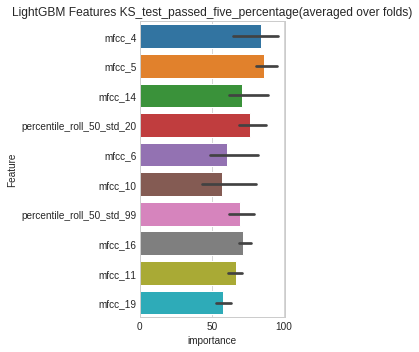

In [132]:
#Feature Importance:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:10].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(5,5))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features KS_test_passed_five_percentage(averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [133]:
y_true=pd.read_csv("first_rank_solution.csv")
y_true=y_true.drop("seg_id",axis=1)
y_true=np.array(y_true)
y_true.ndim


2

In [134]:
y_true=y_true.ravel()
y_true.ndim


1

In [135]:
y_true

array([4.1883685 , 5.7786757 , 7.22398479, ..., 2.38919632, 2.12215348,
       9.80107188])

In [136]:
y_pred= predictions
y_pred

array([4.77838102, 6.42928136, 6.92494922, ..., 2.26189392, 2.23312512,
       8.13843521])

In [137]:
# find the accuracy of model
from sklearn.metrics import mean_absolute_error
y_true
y_pred
mean_absolute_error(y_true, y_pred)

0.44096648515501213

In [139]:
#The coefficient of determination: 1 is perfect prediction
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
print('Coefficient of determination: %.2f'
      % r2_score(y_true,y_pred))

Coefficient of determination: 0.96


In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [ ]:
#Scatter plot of actual vs predicted:
rng = np.random.RandomState(0)
x=y_true
y=y_pred
colors = rng.rand(2624)
sizes = 5 * rng.rand(2624)

plt.xlabel("Actual Price")
plt.ylabel("Predicted price")
plt.title("actual vs predicted Price")
plt.scatter(x, y, c=colors, s=sizes,alpha=0.5,cmap='viridis')
            

plt.show()

In [ ]:
#https://www.w3schools.com/python/python_ml_linear_regression.aspimport matplotlib.pyplot as plt
from scipy import stats
x=y_true
y=y_pred
slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
    return slope * x + intercept

mymodel = list(map(myfunc, x))
size = 5 * rng.rand(2624)
plt.scatter(x, y,s=size)
plt.xlabel("Actual Price",fontsize='xx-large')
plt.ylabel("Predicted price",fontsize='xx-large')
plt.title("actual vs predicted Price",fontsize='xx-large')
plt.plot(x, mymodel)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
x=y_true
y=y_pred
slope, intercept, R_squared_range, p, std_err = stats.linregress(x, y)


In [ ]:
(slope, intercept, R_squared_range, p, std_err)

### The above procedures are the implementation ideas of Kaggle 1st Ranker of this competetion i tried to miminc the solution.
### there thinking procedured is simple and very effective to implement. the main task in this competetion is to do the featurization and find the  cross validation subset such that it generalzes the prediction. 
### The CV dataset they prepaired is for training dataset itself what they did is: they grabed the data point form between the successive earthquakes and then used that dataset to train the model.